## Project 'Histopathologic Cancer Detection'

The project is an old kaggle competition (https://www.kaggle.com/competitions/histopathologic-cancer-detection) which is about identifying metastatic tissue in histopathologic scans of lymph node sections. 

### Data set
The data set comprises of 220025 tif files as training data and 57458 tif files as test data. The training data has to be used to train a CNN model and the model predicts the test images. A further csv file contains a mapping of file name to 'label'. The labels are '0' for no tumor and '1' for tumor. To be more precise, the labels only classify the center 32x32px region of the images. The images are 96x96px but a tumor outside the center 32x32px does not affect the label. Maybe it is possible to use only the center pixels (and maybe a few more in every direction for convolution) as input for the CNN. The images have also three channels (RGB). This means every image contains ~28kByte of data and the whole training data set has more than 6GB. Loading all the images to memory at the same time could lead to swapping on computers with less than 16GB RAM (assuming some python overhead and other system services being in RAM).

There are 130908 images without tumor and 89117 images with tumor. So the data set is imbalanced.

### Goal
For each id in the test set it has to be predicted a probability that center 32x32px region of a patch contains at least one pixel of tumor tissue. The file should contain a header and have the format: 'id, label', while label has to be '0' or '1'.

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.


In [1]:
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Rescaling, Cropping2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


2025-03-27 13:54:49.998057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743080090.013258   12817 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743080090.018106   12817 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743080090.029881   12817 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743080090.029898   12817 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743080090.029900   12817 computation_placer.cc:177] computation placer alr

In [2]:
tf.config.list_physical_devices('GPU') #Check if GPU is recognised

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### EDA and splitting up the data set

Since training a CNN with the full data set is very slow I decided to start with a subset of the full data set. I found a nice idea in one of the kaggle notebooks (https://www.kaggle.com/code/vbookshelf/cnn-how-to-use-160-000-images-without-crashing) which solves several problems at the same time. 
- The data set is split up in a way that four folders are generated on the hard disc and the regarding images are copied into those folders. The folders are one for label '0' and one for label '1', for training and validation respectively.
- This way one can have a look at all images of the particular labels in a file explorer (instead of printing a few in this jupyter notebook).
- Only the four folders are read in and no memory is wasted on the full data set

In [3]:
print("Number of images in the training data set", len(os.listdir('./train')))
print("Number of images in the test data set", len(os.listdir('./test')))

Number of images in the training data set 220025
Number of images in the test data set 57458


In [4]:
df_train = pd.read_csv('train_labels.csv')
df_train['label'].value_counts() #Check distribution of labels

label
0    130908
1     89117
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

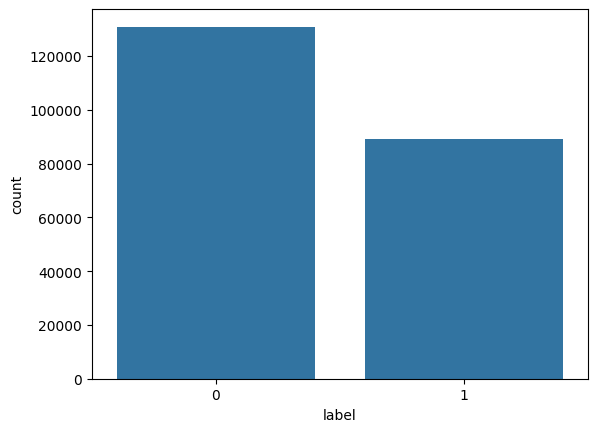

In [5]:
sns.countplot(x='label', data=df_train) #and the distribution as count plot with absolute values

<Axes: xlabel='label', ylabel='percent'>

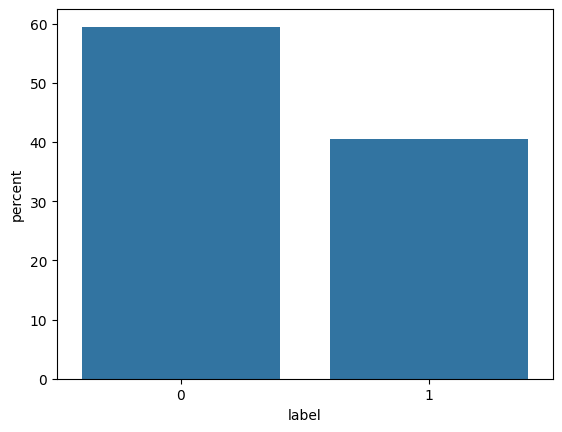

In [6]:
sns.countplot(x='label', data=df_train, stat='percent') #and again the distribution as percentages

In [7]:
# The following code displays some sample images. It is not my code the source can be found below.
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(figure_cols, df):
    categories = (df.groupby(['label'])['label'].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories)))
    for i, cat in enumerate(categories):
        sample = df[df['label']==cat].sample(figure_cols)
        for j in range(0,figure_cols):
            file='./train/'  + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im)
            ax[i, j].set_title(cat)
    plt.tight_layout()
    plt.show()

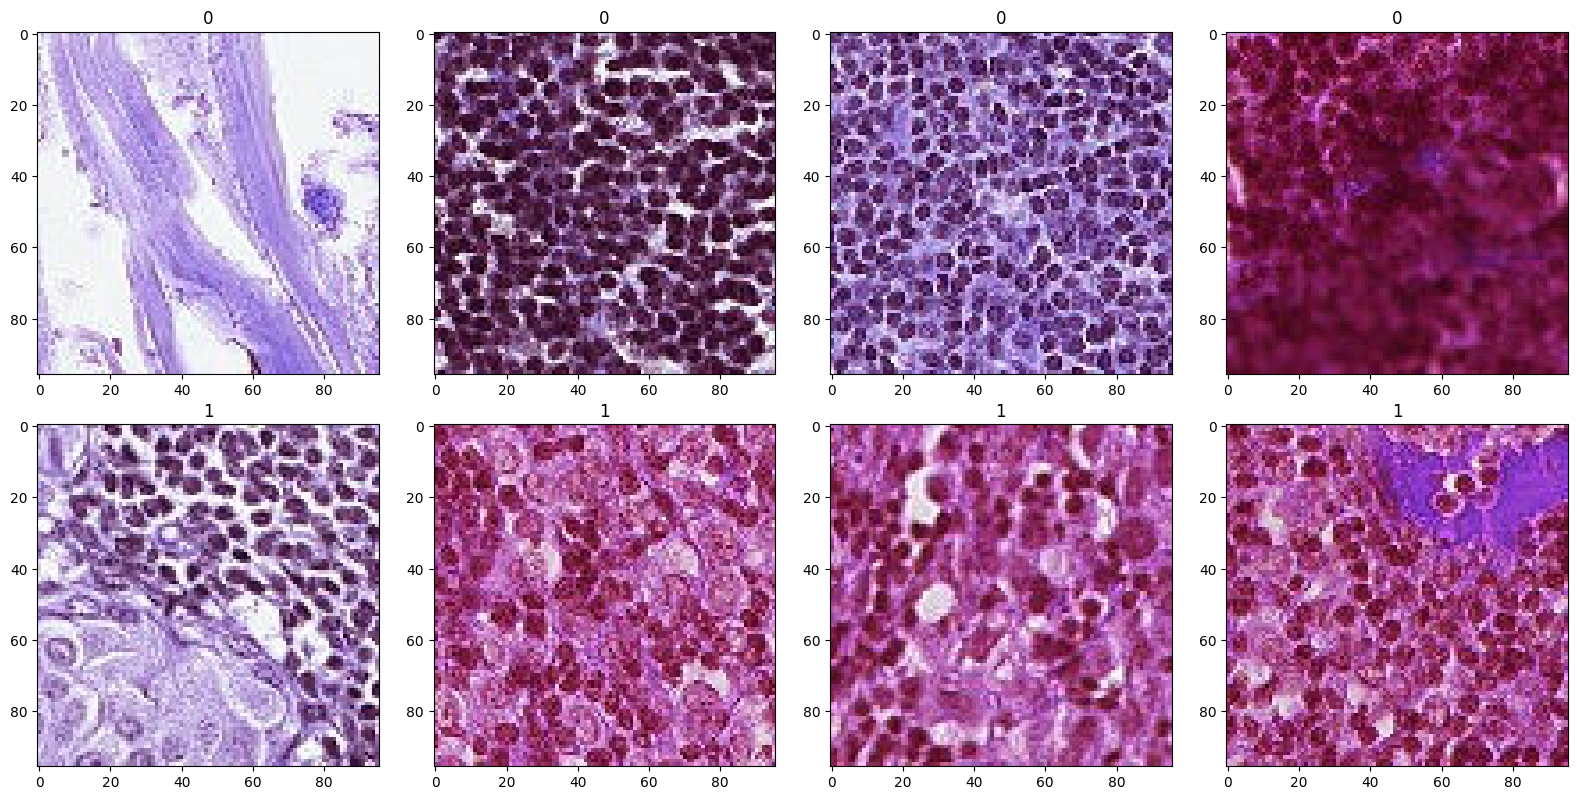

In [8]:
draw_category_images(4, df_train)

In [9]:
df_train.head() #The first 5 rows show the structure of the data frame. 'id' is the file name (without .tif)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [10]:
df_0 = df_train[df_train['label'] == 0].sample(20000, random_state = 42) #take 20000 rows with label 0
df_1 = df_train[df_train['label'] == 1].sample(20000, random_state = 42) #take 20000 rows with label 0
df_train = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)        #merge the two data frames
df_train = shuffle(df_train,random_state=42)                             #shuffle so 0s and 1s are not in order
df_train['label'].value_counts()                                         #check if it was successful

label
1    20000
0    20000
Name: count, dtype: int64

In [11]:
df_train, df_val = train_test_split(df_train, test_size=0.10, random_state=42, stratify=df_train['label'])

In [12]:
subset_dir = 'subset_dir' # root dir for the four new folders
val_dir = os.path.join(subset_dir, 'val_dir') 
train_dir = os.path.join(subset_dir, 'train_dir')
noTumorDir = 'a_no_tumor' #folder name for label 0
tumorDir = 'b_tumor'      #folder name for label 1
def CreateDirs():        
    os.mkdir(subset_dir)
    os.mkdir(train_dir)
    os.mkdir(val_dir)

    no_tumor_tissue = os.path.join(train_dir, noTumorDir)
    os.mkdir(no_tumor_tissue)
    has_tumor_tissue = os.path.join(train_dir, tumorDir)
    os.mkdir(has_tumor_tissue)
    
    no_tumor_tissue = os.path.join(val_dir, noTumorDir)
    os.mkdir(no_tumor_tissue)
    has_tumor_tissue = os.path.join(val_dir, tumorDir)
    os.mkdir(has_tumor_tissue)

#CreateDirs() #only to be called once...

In [13]:
# set columns id as index. this also removes 'id' as a column
df_train.set_index('id', inplace=True)
df_val.set_index('id', inplace=True)

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36000 entries, 7916c11edb4fb7e2ac0f5212e2b15cdabc6424eb to 3903f55cc2284b4279ea68bfe3ef4660bc915f1a
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   36000 non-null  int64
dtypes: int64(1)
memory usage: 562.5+ KB


In [15]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, bb2a13cfd40e7f92d90febf182e848ef9ddb4a32 to 8c2fa5a7ecbf3200920cabe4e49afb70474c3d43
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   4000 non-null   int64
dtypes: int64(1)
memory usage: 62.5+ KB


In [16]:
df_val.head()

,label
id,
bb2a13cfd40e7f92d90febf182e848ef9ddb4a32,1
5c8f2252406568980361cf2727ce8d8f39fb1741,0
2da45b0a87cc707324de4f477d8ac7a53757e6b6,1
7ed84788fe8a5c710f31e3a8a71e5554770c4cd4,1
21f87ba3669b40c66fd04f5ebcc8f605fff644a7,1


In [17]:
df_train.head()

,label
id,
7916c11edb4fb7e2ac0f5212e2b15cdabc6424eb,0
a5e4b0f21f76b19cf51112fe0e0975246f5947f9,1
95cefc0f4ee449cd10c156c1a7306ca332cbced7,0
6d3d776ab73c220c95b3564c05d6361939308b59,0
971c35645963f78c7821bb2b7b41a3a54a667d95,0


In [18]:
def CopyFile(valOrTrainDir, image, df):
    #copy a single file
    fileName = image + '.tif' #add .tif to the file name
    target = df.loc[image,'label'] #get label of the image

    #set label name
    if target == 0:
        label = noTumorDir
    if target == 1:
        label = tumorDir
    
    src = os.path.join('./train', fileName)
    dst = os.path.join(valOrTrainDir, label, fileName)
    shutil.copyfile(src, dst)
    
def CopyImagesOnDisc():
    # Copy images in the proper folder
    for image in list(df_train.index.values): #index is the file name without .tif
        CopyFile(train_dir, image, df_train)
    for image in list(df_val.index.values): #index is the file name without .tif
        CopyFile(val_dir, image, df_val)
        
#CopyImagesOnDisc() #only to be called once...

### Checking brightness and contrast of the images

Now we are going to check brightness and contrast to get an overview of the images. The idea is to find differences between label 0 and label 1. Label 0 can actually be anything as long as it does not show a tumor in the center.

To do so we open all the images in the reduced data set and calculate mean and standard deviation of the pixels. Maybe it would make more sense to check only the center 32x32 but I will leave that for further projects.

In [19]:
def checkBrightnessAndContrast(directory):
    # go through directory and find all images
    # good thing that we copied our subset of images in a new directory so we do not have to filter based on 'id'.
    filePaths = [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith(('.tif'))]
    allMeans = []
    veryDark = []
    veryBright = []
    lowContrast = []
    
    for filePath in filePaths:
        with Image.open(filePath) as img:
            img_array = np.array(img)    #convert to numpy array
            mean = np.mean(img_array)    #calculate mean of all pixels and channels
            if mean >245:                #245 is kind of random...change it if required, same applies to 40 and 8
                veryBright.append(filePath)
            if mean <40:
                veryDark.append(filePath)
            if np.std(img_array) < 8:    #it is possible with a threshold of 8 that the picture shows some structures and is black/white otherwise
                lowContrast.append(filePath)
            allMeans.append(mean)        # collect mean values for a histogram

    plt.figure(figsize=(12, 6))
    sns.histplot(allMeans, bins=30)
    plt.title("Distribution Mean Pixel Brightness")
    plt.xlabel("Mean value")
    plt.ylabel("Count")
    plt.show

    # Some calculations to find out how many sub plots we need...just to make it look a little nice
    # Histogram will be in one row...the other three diagrams share another row
    numberSubPlots = 0
    if len(lowContrast)>0:
        numberSubPlots = numberSubPlots + 1
    if len(veryDark)>0:
        numberSubPlots = numberSubPlots + 1
    if len(veryBright)>0:
        numberSubPlots = numberSubPlots + 1

    curSubPlot = 1
    plt.figure(figsize=(12, 6))
    if len(lowContrast)>0:                                # if we found at least one image with low contrast --> show the image
        ax1 = plt.subplot(1,numberSubPlots,curSubPlot)
        im=cv2.imread(lowContrast[-1])                    #take the last one to avoid showing the same picture twice as low contrast and bright/dark
        ax1.imshow(im, resample=True, cmap='gray')
        ax1.set_title("low contrast")  
        ax1.set_xlabel(os.path.basename(lowContrast[0])[0:25]+ "...") #full name does not really fit unfortunately so let's trim it
        curSubPlot=curSubPlot+1
    if len(veryDark)>0:
        ax1 = plt.subplot(1,numberSubPlots,curSubPlot)
        im=cv2.imread(veryDark[0])
        ax1.imshow(im, resample=True, cmap='gray')
        ax1.set_title("very dark")  
        ax1.set_xlabel(os.path.basename(veryDark[0])[0:25]+ "...")
        curSubPlot = curSubPlot +1
    if len(veryBright)>0:
        ax1 = plt.subplot(1,numberSubPlots,curSubPlot)
        im=cv2.imread(veryBright[0])
        ax1.imshow(im, resample=True, cmap='gray')
        ax1.set_title("very bright")          
        ax1.set_xlabel(os.path.basename(veryBright[0])[0:25]+ "...")
    plt.show()
    
    print("Summary:")
    print("Number of images with low contrast: ", len(lowContrast))
    print("Number of very dark images: ", len(veryDark))
    print("Number of very bright images: ", len(veryBright))

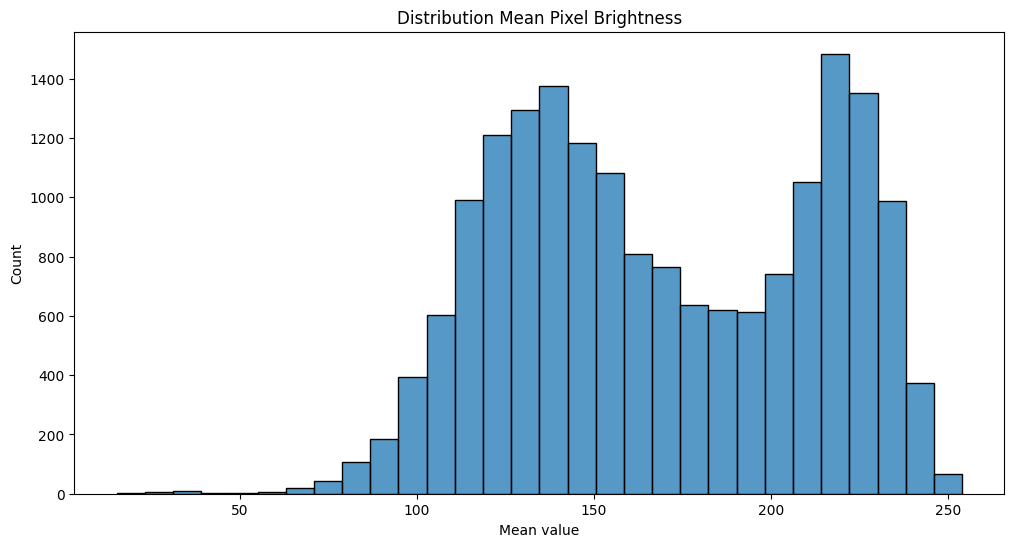

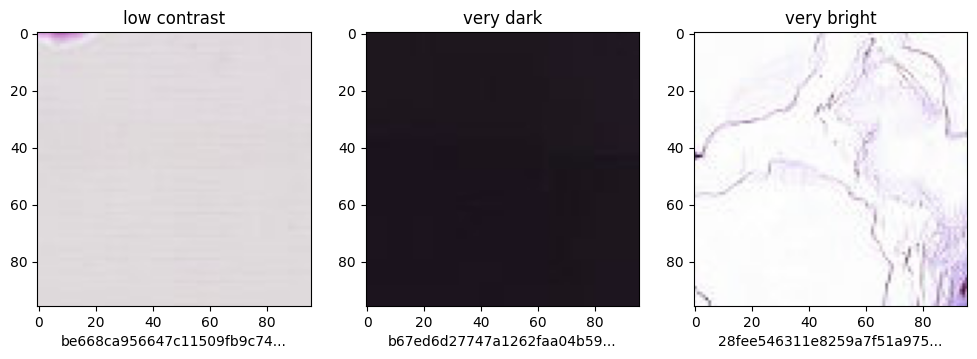

Summary:
Number of images with low contrast:  146
Number of very dark images:  17
Number of very bright images:  85


In [20]:
checkBrightnessAndContrast('./subset_dir/train_dir/a_no_tumor')

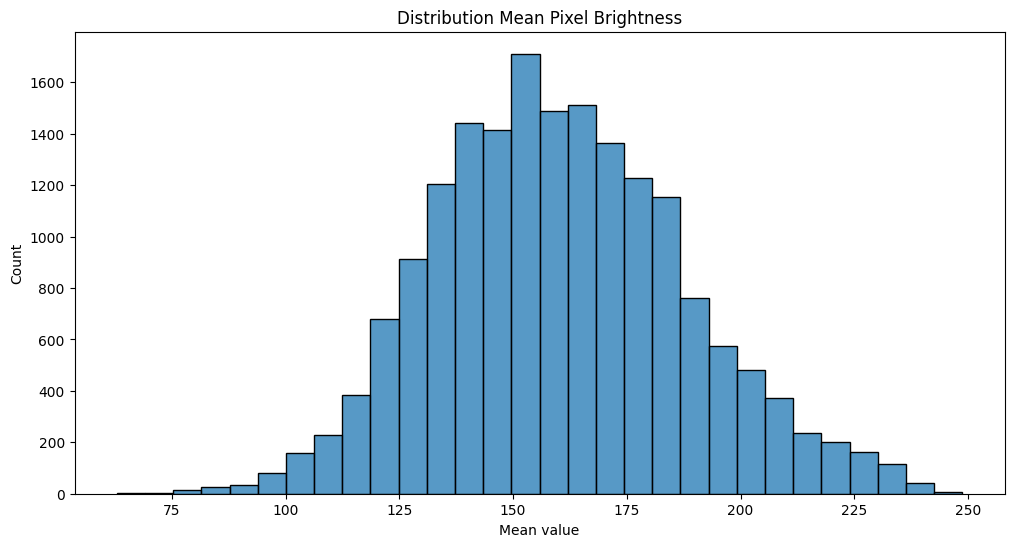

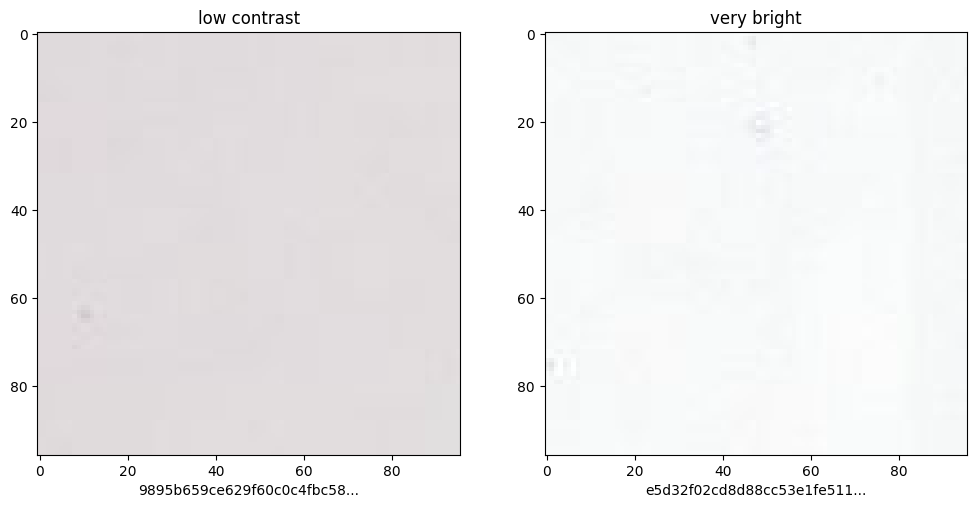

Summary:
Number of images with low contrast:  14
Number of very dark images:  0
Number of very bright images:  3


In [21]:
checkBrightnessAndContrast('./subset_dir/train_dir/b_tumor')

## Result of the EDA

I checked only 20% of the full data set for performance reasons but nonetheless there are results which also apply to the full data set. 
- The cluster of cancerous images contains some images which do not show any signs of cancer because the images are **very bright** or have **very low contrast**. **It might make sense to remove those images from the training data set.** I do not know if the classification for those images is just wrong (seems very likely to me) or if they show cancer but the image quality is bad.
- The cluster of non cancerous images contains images which are - more or less - completely white or completely dark or have very low contrast. **For the non cancerous cluster such images are ok because a completely white image does not show cancer. It is actually good if our model learns that images with no contrast do not show cancer.**
- Group 'no cancer' has a lot more bright pictures than group 'cancer'. The peak of the historgrams for 'cancer' is at ~ 150 and the other group has two peaks one at ~130 and one at ~230.
- Low contrast, very dark, very bright images are mostly in group 'no cancer'.

--> In theory we could build a hybrid model where we take this kind of information into account but this is beyond the project here.

Next we need calculate the steps on the training and validation set. A 'wrong' value leads to bad performance of the models.

In [22]:
num_train_samples = len(df_train)
print('num_train_samples',num_train_samples)
num_val_samples = len(df_val)
print('num_val_samples',num_val_samples)
train_batch_size = 30
val_batch_size = 30

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
print('train_steps',train_steps)
print('val_steps',val_steps)


num_train_samples 36000
num_val_samples 4000
train_steps 1200.0
val_steps 134.0


In [23]:
train_steps = int(train_steps) #convert from float64 to int or you get an error message in model.fit
val_steps = int(val_steps)

In [24]:
# Create a generator that reads the images from disc and assings the respective labels.
# rescaling because the pixel values are between 0 and 254 and we want them to be between 0 and 1
datagen = ImageDataGenerator(rescale=1.0/255)  

train_gen = datagen.flow_from_directory(train_dir,
                                        target_size=(96,96),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(val_dir,
                                        target_size=(96,96),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')


Found 36000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


Before we create our models I would like to give an overview of the layers in keras which might be useful for our task. (descriptions from https://keras.io/api/layers)
- Conv2D: This layer creates a convolution kernel that is convolved with the layer.
   - Important parameters:
      - filters: the dimension of the output space (the number of filters in the convolution).
      - kernel_size: int or tuple/list of 2 integers, specifying the size of the convolution window.
- MaxPooling2D: Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.
    - Example: Am input of shape (1,3,3,1) is given to a MaxPooling2d layer with pool_size=strides=(2,2), the output is of shape (1,1,1,1)
- Dropout: The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
   - rate: Float between 0 and 1. Fraction of the input units to drop.
- Flatten: Flattens the input. E.g. if you flatten an input of shape (10,64) the result is of shape (None, 640)
- Dense: Implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).

### Models and parameter tuning
- We will train our models first with a subset of the full training data.
- We are going to start with one of the most simple CNNs, i.e. one Conv2D and one MaxPooling2D layer
- We will check the influence of the kernel size on the learning
- Then we will create a more complex model with more layers and hope it can 'store' more information
- We will create a submission file and check the performance based on the small training data set
- Finally we will train the best model with the whole training data set and create a submission file

In [25]:
def RunFit(modelFileName, model, earlyStoppingPatience=2):
    # Stop if the validation loss does not go down any more...should save time and avoid overfitting
    earlyStopping = EarlyStopping(monitor='val_loss', patience=earlyStoppingPatience, verbose=1)   
    # Save model parameters so we do not have to run the training over and over again
    checkpoint = ModelCheckpoint(modelFileName, monitor='val_loss', verbose=1, 
                                 save_best_only=True, mode='max', save_weights_only=True)  
    # Reduce learning rate if we hit a plateau.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, 
                                       verbose=1, mode='max', min_lr=0.00001)                                                        
    callbacks_list = [checkpoint, reduce_lr, earlyStopping]
    history = model.fit(train_gen, steps_per_epoch=train_steps, 
                        validation_data=val_gen,
                        validation_steps=val_steps,
                        epochs=20, verbose=1,
                       callbacks=callbacks_list)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    tmp = pd.DataFrame({'accuracy':history.history['accuracy'], 'val_accuracy':history.history['val_accuracy']})
    sns.lineplot(tmp)
    plt.show
    plt.figure()
    tmp = pd.DataFrame({'loss':history.history['loss'], 'val_loss':history.history['val_loss']})
    sns.lineplot(tmp)
    plt.show

In [26]:
simpleModel_3_3 = Sequential()
simpleModel_3_3.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (96, 96, 3)))
simpleModel_3_3.add(MaxPooling2D(pool_size = (2,2))) 
simpleModel_3_3.add(Dropout(0.3))
simpleModel_3_3.add(Flatten())
simpleModel_3_3.add(Dense(2, activation = "sigmoid"))

simpleModel_3_3.summary()

I0000 00:00:1743080112.110385   12817 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7051 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 70688)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │       141,378 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,274 (555.76 KB)

 Trainable params: 142,274 (555.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1743080113.367781   12914 service.cc:152] XLA service 0x78cbb8003260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743080113.367819   12914 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2025-03-27 13:55:13.387739: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743080113.497149   12914 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-27 13:55:13.803564: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.3 = (f32[30,32,94,94]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,3,96,96]{3,2,1,0} %bitcast.3681, f32[32,3,3,3]{3,2,1,0} %bitcast.3688, f32[32]{0} %bitcast.4041), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasA

  14/1200 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.4875 - loss: 0.7036

I0000 00:00:1743080114.755512   12914 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7249 - loss: 0.5471

2025-03-27 13:55:31.110976: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.3 = (f32[30,32,94,94]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,3,96,96]{3,2,1,0} %bitcast.459, f32[32,3,3,3]{3,2,1,0} %bitcast.466, f32[32]{0} %bitcast.468), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/chris/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-27 13:55:45.355016: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng


Epoch 1: val_loss improved from -inf to 0.48086, saving model to simpleModel_3_3.weights.h5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.7249 - loss: 0.5470 - val_accuracy: 0.7753 - val_loss: 0.4809 - learning_rate: 1.0000e-04
Epoch 2/20
1198/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7841 - loss: 0.4732
Epoch 2: val_loss did not improve from 0.48086

Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7841 - loss: 0.4732 - val_accuracy: 0.7922 - val_loss: 0.4602 - learning_rate: 1.0000e-04
Epoch 3/20
1197/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7925 - loss: 0.4569
Epoch 3: val_loss did not improve from 0.48086

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7925 - loss: 0.4569 - val_accuracy: 0.7933 - val_loss: 0.4570 - learning_rate: 5.0000e-05
Epoch 4/20
1197/1200 ━━━━━━━━━━━━━

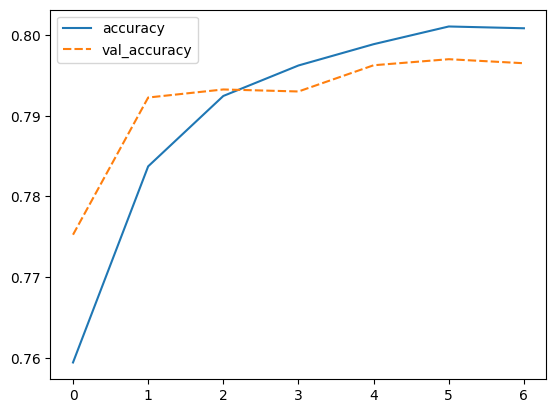

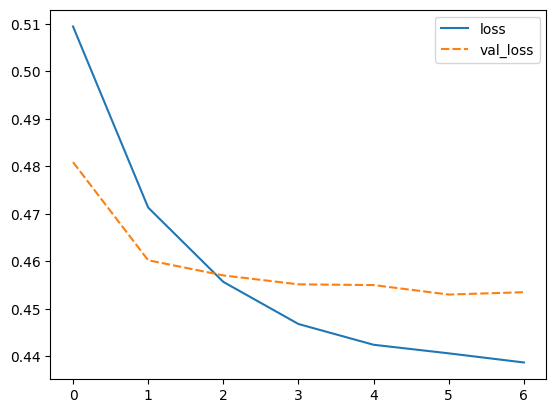

In [27]:
simpleModel_3_3.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
modelName = 'simpleModel_3_3.weights.h5'
if os.path.isfile(modelName):
    simpleModel_3_3.load_weights(modelName)
else:
    RunFit(modelName, simpleModel_3_3, earlyStoppingPatience=0)

In [28]:
simpleModel_2_2 = Sequential()
simpleModel_2_2.add(Conv2D(32, (2,2), activation = 'relu', input_shape = (96, 96, 3)))
simpleModel_2_2.add(MaxPooling2D(pool_size = (2,2))) 
simpleModel_2_2.add(Dropout(0.3))
simpleModel_2_2.add(Flatten())
simpleModel_2_2.add(Dense(2, activation = "sigmoid"))

simpleModel_2_2.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

simpleModel_2_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 95, 95, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 70688)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │       141,378 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,794 (553.88 KB)

 Trainable params: 141,794 (553.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1197/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7043 - loss: 0.5696
Epoch 1: val_loss improved from -inf to 0.48277, saving model to simpleModel_2_2.weights.h5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7044 - loss: 0.5695 - val_accuracy: 0.7770 - val_loss: 0.4828 - learning_rate: 1.0000e-04
Epoch 2/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7810 - loss: 0.4837
Epoch 2: val_loss did not improve from 0.48277

Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7810 - loss: 0.4837 - val_accuracy: 0.7887 - val_loss: 0.4693 - learning_rate: 1.0000e-04
Epoch 3/20
1197/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7895 - loss: 0.4681
Epoch 3: val_loss did not improve from 0.48277

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7895 - loss: 0.4681 - val_accuracy: 

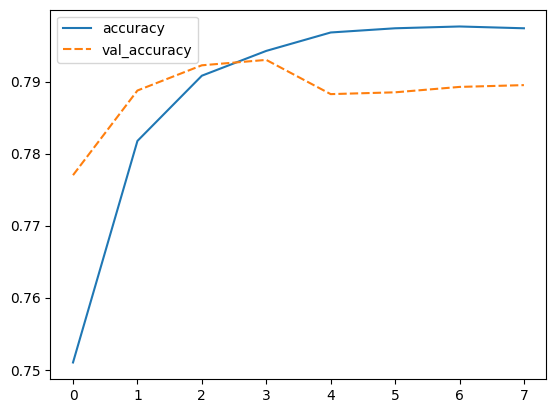

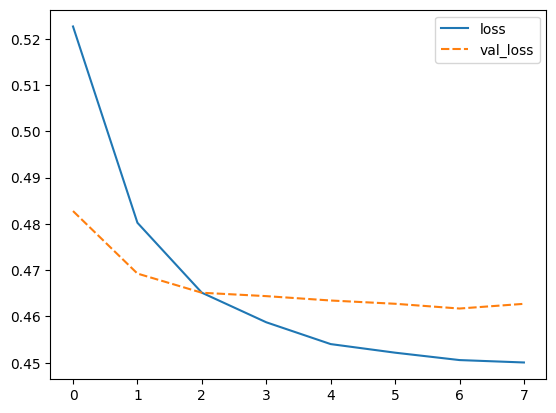

In [29]:
simpleModel_2_2.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
modelName = 'simpleModel_2_2.weights.h5'
if os.path.isfile(modelName):
    simpleModel_2_2.load_weights(modelName)
else:
    RunFit(modelName, simpleModel_2_2, earlyStoppingPatience=0)

In [30]:
simpleModel_5_5 = Sequential()
simpleModel_5_5.add(Conv2D(32, (5,5), activation = 'relu', input_shape = (96, 96, 3)))
simpleModel_5_5.add(MaxPooling2D(pool_size = (2,2))) 
simpleModel_5_5.add(Dropout(0.3))
simpleModel_5_5.add(Flatten())
simpleModel_5_5.add(Dense(2, activation = "sigmoid"))

simpleModel_5_5.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

simpleModel_5_5.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 92, 92, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │       135,426 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,858 (538.51 KB)

 Trainable params: 137,858 (538.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-03-27 13:59:52.229946: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.3 = (f32[30,32,92,92]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,3,96,96]{3,2,1,0} %bitcast.3681, f32[32,3,5,5]{3,2,1,0} %bitcast.3688, f32[32]{0} %bitcast.4041), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_2_1/convolution" source_file="/home/chris/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


1198/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7200 - loss: 0.5613

2025-03-27 14:00:09.822168: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.3 = (f32[30,32,92,92]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,3,96,96]{3,2,1,0} %bitcast.459, f32[32,3,5,5]{3,2,1,0} %bitcast.466, f32[32]{0} %bitcast.468), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_2_1/convolution" source_file="/home/chris/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-27 14:00:11.832471: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm


Epoch 1: val_loss improved from -inf to 0.47443, saving model to simpleModel_5_5.weights.h5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.7200 - loss: 0.5612 - val_accuracy: 0.7870 - val_loss: 0.4744 - learning_rate: 1.0000e-04
Epoch 2/20
1196/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7797 - loss: 0.4783
Epoch 2: val_loss did not improve from 0.47443

Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7797 - loss: 0.4783 - val_accuracy: 0.7860 - val_loss: 0.4607 - learning_rate: 1.0000e-04
Epoch 3/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7869 - loss: 0.4617
Epoch 3: val_loss did not improve from 0.47443

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.7869 - loss: 0.4617 - val_accuracy: 0.7997 - val_loss: 0.4505 - learning_rate: 5.0000e-05
Epoch 4/20
1199/1200 ━━━━━━━━━━━━━

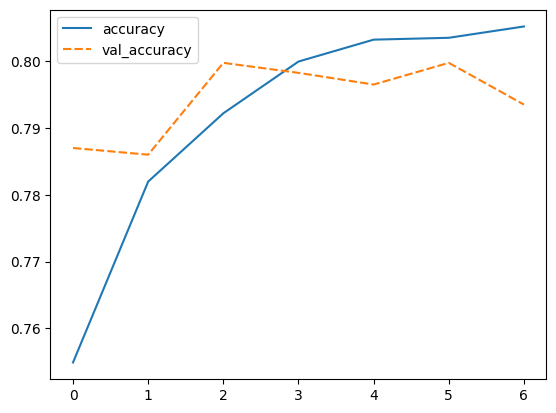

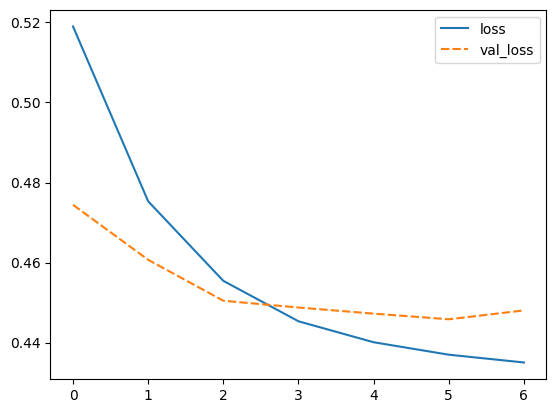

In [31]:
simpleModel_5_5.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
modelName = 'simpleModel_5_5.weights.h5'
if os.path.isfile(modelName):
    simpleModel_5_5.load_weights(modelName)
else:
    RunFit(modelName, simpleModel_5_5, earlyStoppingPatience=0)

In [32]:
model3Times3TimesConv2DMaxPooling = Sequential()
model3Times3TimesConv2DMaxPooling.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (96, 96, 3)))
model3Times3TimesConv2DMaxPooling.add(MaxPooling2D(pool_size = (2,2))) 
model3Times3TimesConv2DMaxPooling.add(Dropout(0.3))

model3Times3TimesConv2DMaxPooling.add(Conv2D(64, (3,3), activation ='relu'))
model3Times3TimesConv2DMaxPooling.add(MaxPooling2D(pool_size = (2,2)))
model3Times3TimesConv2DMaxPooling.add(Dropout(0.3))

model3Times3TimesConv2DMaxPooling.add(Conv2D(128, (3,3), activation ='relu'))
model3Times3TimesConv2DMaxPooling.add(MaxPooling2D(pool_size = (2,2)))
model3Times3TimesConv2DMaxPooling.add(Dropout(0.3))

model3Times3TimesConv2DMaxPooling.add(Flatten())
model3Times3TimesConv2DMaxPooling.add(Dense(256, activation = "relu"))
model3Times3TimesConv2DMaxPooling.add(Dropout(0.3))
model3Times3TimesConv2DMaxPooling.add(Dense(2, activation = "sigmoid"))

model3Times3TimesConv2DMaxPooling.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

model3Times3TimesConv2DMaxPooling.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,818 (12.86 MB)

 Trainable params: 3,370,818 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-03-27 14:01:58.134875: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.10 = (f32[30,64,45,45]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,32,47,47]{3,2,1,0} %bitcast.12941, f32[64,32,3,3]{3,2,1,0} %bitcast.12267, f32[64]{0} %bitcast.13001), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_3_1/conv2d_4_1/convolution" source_file="/home/chris/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-27 14:01:58.199231: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy 

1198/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6610 - loss: 0.6001

2025-03-27 14:02:16.976797: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.10 = (f32[30,64,45,45]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,32,47,47]{3,2,1,0} %bitcast.558, f32[64,32,3,3]{3,2,1,0} %bitcast.565, f32[64]{0} %bitcast.567), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_3_1/conv2d_4_1/convolution" source_file="/home/chris/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-27 14:02:17.034752: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algori


Epoch 1: val_loss improved from -inf to 0.55403, saving model to model3Times3TimesConv2DMaxPooling.weights.h5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.6612 - loss: 0.6000 - val_accuracy: 0.7172 - val_loss: 0.5540 - learning_rate: 1.0000e-04
Epoch 2/20
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7740 - loss: 0.4857
Epoch 2: val_loss did not improve from 0.55403

Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7740 - loss: 0.4857 - val_accuracy: 0.7312 - val_loss: 0.5428 - learning_rate: 1.0000e-04
Epoch 3/20
1197/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7834 - loss: 0.4733
Epoch 3: val_loss did not improve from 0.55403

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7834 - loss: 0.4733 - val_accuracy: 0.7722 - val_loss: 0.4993 - learning_rate: 5.0000e-05
Epoch 4/20
1200/

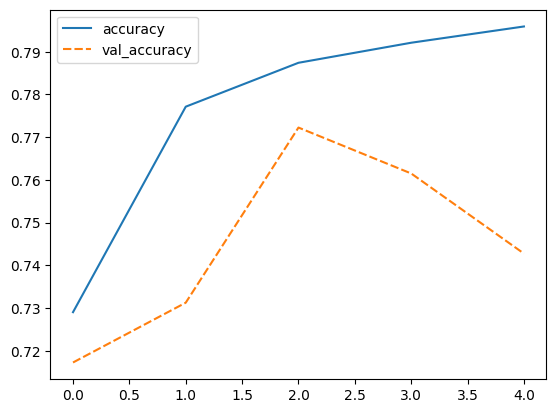

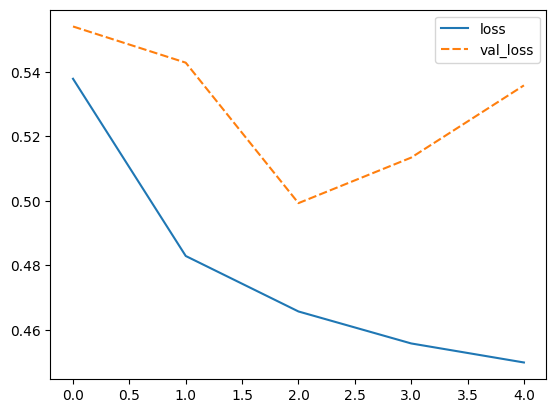

In [33]:
model3Times3TimesConv2DMaxPooling.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
modelName = 'model3Times3TimesConv2DMaxPooling.weights.h5'
if os.path.isfile(modelName):
    model3Times3TimesConv2DMaxPooling.load_weights(modelName)
else:
    RunFit(modelName, model3Times3TimesConv2DMaxPooling, earlyStoppingPatience=2)

In [34]:
complexModelBatchNormalization = Sequential()
complexModelBatchNormalization.add(Input(shape=(96, 96, 3)))
complexModelBatchNormalization.add(Conv2D(32, (3,3), activation='relu'))
complexModelBatchNormalization.add(BatchNormalization())
complexModelBatchNormalization.add(MaxPooling2D((2,2)))
complexModelBatchNormalization.add(Conv2D(64, (3,3), activation='relu'))
complexModelBatchNormalization.add(BatchNormalization())
complexModelBatchNormalization.add(MaxPooling2D((2,2)))
complexModelBatchNormalization.add(Conv2D(128, (3,3), activation='relu'))
complexModelBatchNormalization.add(BatchNormalization())
complexModelBatchNormalization.add(MaxPooling2D((2,2)))
complexModelBatchNormalization.add(Conv2D(256, (3,3), activation='relu'))
complexModelBatchNormalization.add(BatchNormalization())
complexModelBatchNormalization.add(MaxPooling2D((2,2)))
complexModelBatchNormalization.add(Conv2D(512, (3,3), activation='relu'))
complexModelBatchNormalization.add(BatchNormalization())
complexModelBatchNormalization.add(MaxPooling2D((2,2)))
complexModelBatchNormalization.add(Flatten())
complexModelBatchNormalization.add(Dense(256, activation='relu'))
complexModelBatchNormalization.add(Dropout(0.3))
complexModelBatchNormalization.add(Dense(2, activation='sigmoid'))

complexModelBatchNormalization.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
complexModelBatchNormalization.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,386 (6.50 MB)

 Trainable params: 1,702,402 (6.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/20


2025-03-27 14:03:34.238108: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.15 = (f32[30,256,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,128,10,10]{3,2,1,0} %bitcast.10071, f32[256,128,3,3]{3,2,1,0} %bitcast.8217, f32[256]{0} %bitcast.10131), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_4_1/conv2d_9_1/convolution" source_file="/home/chris/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


1197/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7709 - loss: 0.5159

2025-03-27 14:03:53.808434: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.15 = (f32[30,256,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,128,10,10]{3,2,1,0} %bitcast.940, f32[256,128,3,3]{3,2,1,0} %bitcast.947, f32[256]{0} %bitcast.949), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_4_1/conv2d_9_1/convolution" source_file="/home/chris/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-27 14:03:55.795967: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy alg


Epoch 1: val_loss improved from -inf to 0.38878, saving model to complexModelBatchNormalization.weights.h5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.7710 - loss: 0.5157 - val_accuracy: 0.8405 - val_loss: 0.3888 - learning_rate: 1.0000e-04
Epoch 2/20
1197/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8373 - loss: 0.3787
Epoch 2: val_loss did not improve from 0.38878

Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8373 - loss: 0.3787 - val_accuracy: 0.8487 - val_loss: 0.3471 - learning_rate: 1.0000e-04
Epoch 3/20
1197/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8664 - loss: 0.3210
Epoch 3: val_loss did not improve from 0.38878

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8664 - loss: 0.3210 - val_accuracy: 0.8700 - val_loss: 0.3072 - learning_rate: 5.0000e-05
Epoch 4/20
1197/120

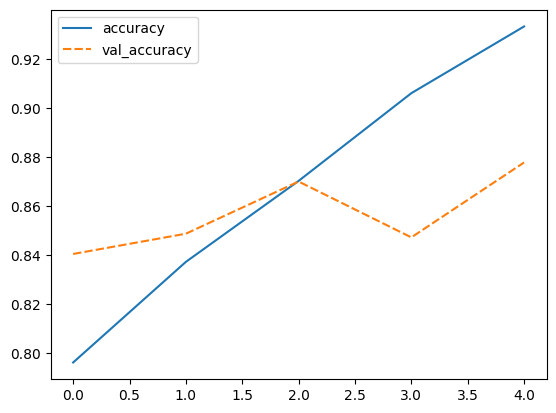

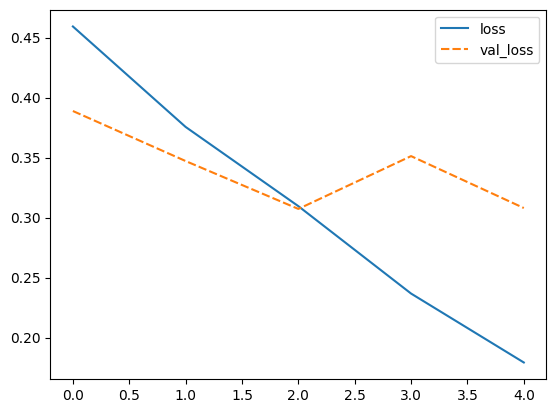

In [35]:
complexModelBatchNormalization.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
modelName = 'complexModelBatchNormalization.weights.h5'
if os.path.isfile(modelName):
    complexModelBatchNormalization.load_weights(modelName)
else:
    RunFit(modelName, complexModelBatchNormalization, earlyStoppingPatience=2)

In [36]:
test_generator =  datagen.flow_from_directory( './',
                                                batch_size  = 32,
                                                class_mode  = 'categorical',
                                                classes = ['test'] ,  #take test dir from ./
                                                shuffle = False,      #keep order of the submission file for easier comparison
                                                target_size = (96, 96))

Found 57458 images belonging to 1 classes.


In [37]:
predictions = complexModelBatchNormalization.predict(test_generator, steps=len(test_generator))
predictions.shape

2025-03-27 14:05:10.794714: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.12 = (f32[32,32,94,94]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,96,96]{3,2,1,0} %bitcast.479, f32[32,3,3,3]{3,2,1,0} %bitcast.486, f32[32]{0} %bitcast.488), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_4_1/conv2d_6_1/convolution" source_file="/home/chris/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-27 14:05:10.809646: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorith

1793/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

2025-03-27 14:05:34.351095: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.12 = (f32[18,32,94,94]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,3,96,96]{3,2,1,0} %bitcast.479, f32[32,3,3,3]{3,2,1,0} %bitcast.486, f32[32]{0} %bitcast.488), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_4_1/conv2d_6_1/convolution" source_file="/home/chris/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-27 14:05:34.361511: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorith

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step


(57458, 2)

In [38]:
predictions[0]

array([0.17434141, 0.8816539 ], dtype=float32)

We can see above that our last dense layer with sigmoid activation function returns two probabilities, one for each of the two labels.



In [39]:
pred = pd.DataFrame({'id': [file[5:-4]for file in test_generator.filenames], 'label': np.argmax(predictions,axis=1)})
pred.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [40]:
pred.to_csv('predictions_small_trainingset.csv', index=False)

In [41]:
df_train = pd.read_csv('train_labels.csv')
df_train = df_train.astype('string') #TypeError: If class_mode="categorical", y_col="label" column values must be strings.
df_train["id"]=df_train["id"].apply(lambda x: x+'.tif')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  string
dtypes: object(1), string(1)
memory usage: 3.4+ MB


In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

def RunFitFullDataSet(df, modelFileName, model, earlyStoppingPatience=2):
    df_train_full, df_val_full = train_test_split(df, test_size=0.10, random_state=42)
    
    datagenTrain = ImageDataGenerator( rescale = 1.0/255.)
    train_gen_full = datagenTrain.flow_from_dataframe(
                                        dataframe=df_train_full,
                                        directory='./train',
                                        x_col= 'id',
                                        y_col= 'label',
                                        batch_size=32,
                                        seed=42,
                                        shuffle=True, 
                                        class_mode='categorical', 
                                        target_size = (96,96))
    datagenVal = ImageDataGenerator( rescale = 1.0/255.)
    val_gen_full = datagenVal.flow_from_dataframe(
                                                dataframe=df_val_full,
                                                directory='./train',
                                                x_col= 'id',
                                                y_col= 'label',
                                                batch_size=32,
                                                seed=42,
                                                shuffle=False, 
                                                class_mode='categorical', 
                                                target_size = (96,96))
    
    num_train_samples = len(df_train_full)
    num_val_samples = len(df_val_full)
    train_steps = np.ceil(num_train_samples / 32)
    train_steps = int(train_steps)
    val_steps = np.ceil(num_val_samples / 32)
    val_steps = int(val_steps)
    print("train_steps",train_steps,"val_steps",val_steps)
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=earlyStoppingPatience, verbose=1)   
    checkpoint = ModelCheckpoint(modelFileName, monitor='val_loss', verbose=1, 
                                 save_best_only=True, mode='max', save_weights_only=True)  
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, 
                                       verbose=1, mode='max', min_lr=0.00001)                                                        
    callbacks_list = [checkpoint, earlyStopping, reduce_lr]
    model.fit(train_gen, 
              steps_per_epoch=train_steps,             
              validation_data=val_gen_full,
              validation_steps=val_steps,
              epochs=20,
              verbose=2,
              callbacks=callbacks_list)
    predictions = model.predict(val_gen_full, steps=len(val_gen_full))
    #predictions = np.argmax(predictions,axis=1)
    predictions = predictions[:,1]

    fpr, tpr, _  = roc_curve(df_val_full['label'].astype(int),  predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    

Found 198022 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.
train_steps 6189 val_steps 688
Epoch 1/20


2025-03-27 14:06:08.531337: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.12 = (f32[19,32,94,94]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,3,96,96]{3,2,1,0} %bitcast.828, f32[32,3,3,3]{3,2,1,0} %bitcast.835, f32[32]{0} %bitcast.837), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_5_1/conv2d_11_1/convolution" source_file="/home/chris/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-27 14:06:08.540005: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorit


Epoch 1: val_loss improved from -inf to 0.36041, saving model to complexModelBatchNormalizationFull.weights.h5
6189/6189 - 32s - 5ms/step - accuracy: 0.7932 - loss: 0.4708 - val_accuracy: 0.8444 - val_loss: 0.3604 - learning_rate: 1.0000e-04
Epoch 2/20

Epoch 2: val_loss improved from 0.36041 to 0.36641, saving model to complexModelBatchNormalizationFull.weights.h5
6189/6189 - 26s - 4ms/step - accuracy: 0.8316 - loss: 0.3892 - val_accuracy: 0.8415 - val_loss: 0.3664 - learning_rate: 1.0000e-04
Epoch 3/20

Epoch 3: val_loss did not improve from 0.36641

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
6189/6189 - 25s - 4ms/step - accuracy: 0.8489 - loss: 0.3501 - val_accuracy: 0.8690 - val_loss: 0.3099 - learning_rate: 1.0000e-04
Epoch 4/20

Epoch 4: val_loss did not improve from 0.36641

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
6189/6189 - 25s - 4ms/step - accuracy: 0.8849 - loss: 0.2804 - val_accuracy: 0.8657 - val_loss: 0

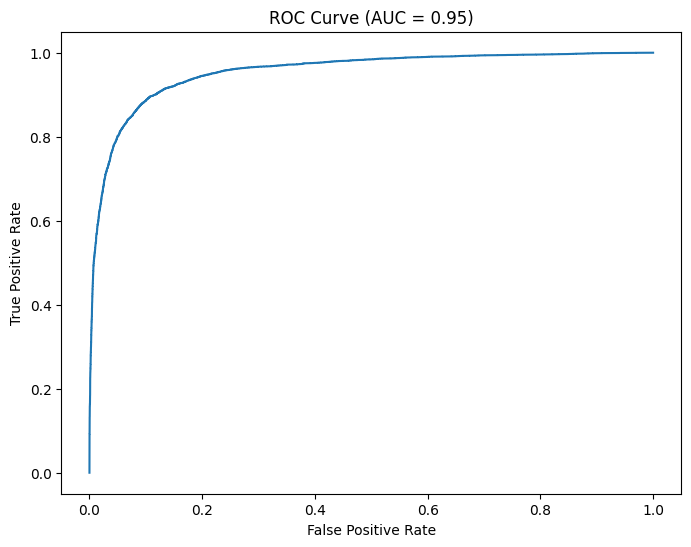

In [43]:
complexModelBatchNormalization = Sequential()
complexModelBatchNormalization.add(Input(shape=(96, 96, 3)))
complexModelBatchNormalization.add(Conv2D(32, (3,3), activation='relu'))
complexModelBatchNormalization.add(BatchNormalization())
complexModelBatchNormalization.add(MaxPooling2D((2,2)))
complexModelBatchNormalization.add(Conv2D(64, (3,3), activation='relu'))
complexModelBatchNormalization.add(BatchNormalization())
complexModelBatchNormalization.add(MaxPooling2D((2,2)))
complexModelBatchNormalization.add(Conv2D(128, (3,3), activation='relu'))
complexModelBatchNormalization.add(BatchNormalization())
complexModelBatchNormalization.add(MaxPooling2D((2,2)))
complexModelBatchNormalization.add(Conv2D(256, (3,3), activation='relu'))
complexModelBatchNormalization.add(BatchNormalization())
complexModelBatchNormalization.add(MaxPooling2D((2,2)))
complexModelBatchNormalization.add(Conv2D(512, (3,3), activation='relu'))
complexModelBatchNormalization.add(BatchNormalization())
complexModelBatchNormalization.add(MaxPooling2D((2,2)))
complexModelBatchNormalization.add(Flatten())
complexModelBatchNormalization.add(Dense(256, activation='relu'))
complexModelBatchNormalization.add(Dropout(0.5))
# if I set the classes of the last layer to 1: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 2), output.shape=(None, 1)
complexModelBatchNormalization.add(Dense(2, activation='sigmoid')) 

complexModelBatchNormalization.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

modelName = 'complexModelBatchNormalizationFull.weights.h5'
if os.path.isfile(modelName):
    complexModelBatchNormalization.load_weights(modelName)
else:
    RunFitFullDataSet(df_train, modelName, complexModelBatchNormalization, earlyStoppingPatience=3)

In [44]:
predictions = complexModelBatchNormalization.predict(test_generator, steps=len(test_generator))
pred = pd.DataFrame({'id': [file[5:-4]for file in test_generator.filenames], 'label': np.argmax(predictions,axis=1)})
pred.to_csv('predictions_full_trainingset.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step


In [45]:
predictionsCol2 = predictions[:,1].copy()
pred = pd.DataFrame({'id': [file[5:-4]for file in test_generator.filenames], 'label': predictionsCol2})
pred.to_csv('predictions_full_trainingset_prob.csv', index=False)

In [46]:
predictions = simpleModel_3_3.predict(test_generator, steps=len(test_generator))

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step


In [47]:
predictionsCol2 = predictions[:,1].copy()
pred = pd.DataFrame({'id': [file[5:-4]for file in test_generator.filenames], 'label': predictionsCol2})
pred.to_csv('predictions_simple_model_full_trainingset_prob.csv', index=False)

### Kaggle submission
I trained the last model three times with the full training data set and submitted the prediction to Kaggle. The next screenshot shows the results of one run of the fit method with an accuracy of .9588 and validation accuracy of .8856.

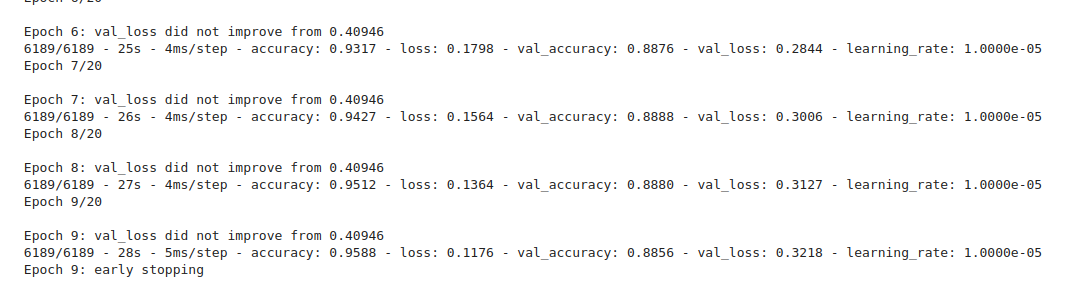

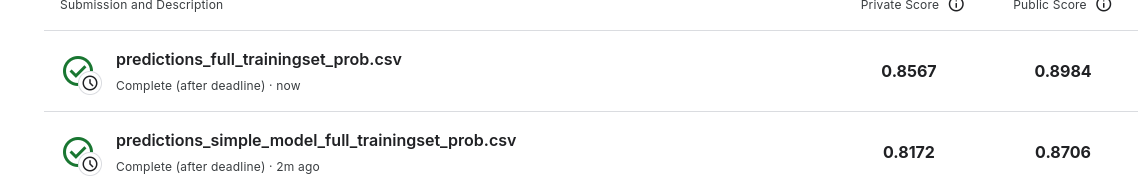

### Conclusion and what I learned
- I ran all the models several times over the last days and the differences betweens the runs were much bigger than expected. Those differences make hyperparameter tuning nearly impossible. I tried to set several seeds (numpy, keras, tensorflow) as described on the keras man pages (https://keras.io/examples/keras_recipes/reproducibility_recipes/) but it did not lead to any reproducibility.
- At first I had a bug splitting up the big data set and even I did a quick check on the result I did not see the bug. This lead to low accuracy of ~0.75 with all models. Even the data set is that big I should have implemented a sanity check for splitting up the data set instead of checking a couple of rows.
- Copying the subset of the full data set into a new folder structure was error prone (I forgot to set a random_state in one place) but it was quite helpful to be able to have a look at tumor and no-tumor pictures without having to check the csv file.
- Performance of the training was also quite unpredictable. Training time of the most simple model with the reduced data set took between 6ms per step to 300ms per step. Unfortunately I could not really find out what the problem was but I have some ideas. Either CPU/GPU became too hot after a while or there was a memory/swapping problem or some other os background process was using the hard disc. Maybe it would have been better not to run this project on a local pc.